# Introduction
## Sentiment Analysis
### Toxic Comments Classification (Toxic, Severe Toxic,Obsence, Threat,  Insult, Identitiy Hated)

In [1]:
## Import lib need
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import re

from keras.preprocessing.text import Tokenizer

import nltk
##nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

In [2]:
## Read File
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Exploration

In [3]:
## Show the details of train data
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
## Show the details of test data
test.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,6639fcfaeb932e35,""" \n ::The link is borderline relevant, in tha..."
freq,1,1


In [5]:
## Show the top 5 of train data
print(train.count())
train.head()

id               159571
comment_text     159571
toxic            159571
severe_toxic     159571
obscene          159571
threat           159571
insult           159571
identity_hate    159571
dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
## Show the top 5 of test data
print(test.count())
test.head()

id              153164
comment_text    153164
dtype: int64


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
#Check what would be toxic?
train[train.toxic == 1].head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


# CHECK THE LABELS DISTRIBUTION

In [8]:
# to know the positive ratio of training set
#prevent target wrongly
def get_pos_ratio(data):
    ratio = data.sum() / len(data)
    print(ratio)
    return ratio

pos_ratio = []
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    pos_ratio.append(get_pos_ratio(train[col]))

0.09584448302009764
0.009995550569965721
0.052948217407925
0.002995531769557125
0.04936360616904074
0.00880485802558109


In [9]:
assert pos_ratio[0] == 0.09584448302009764, "The answer is not correct."
print("Congrats, you passed the test.")

Congrats, you passed the test.


# SHOW OCCURENCES

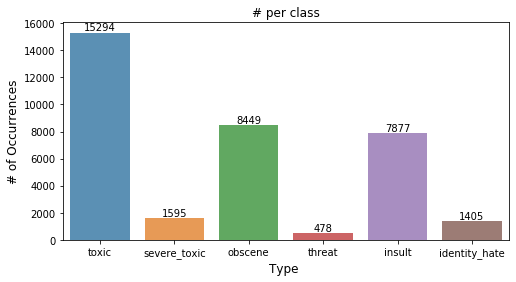

In [10]:
x = train.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# SHOW CORRELATIONS OF LABELS

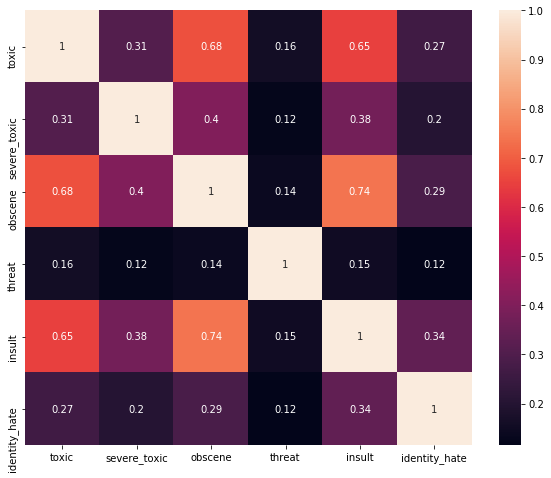

In [11]:
#this is multi-label classification hence , we need to know the relation between labels, which helps for feature engineering and model design
corr=train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

# DATA PREPROCESSING

In [12]:
## Check is there any null
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [13]:
## Check is there any null
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [14]:
## Drop NA record *Just in Case ;)*
train.dropna(inplace=True)
test.dropna(inplace=True)

In [15]:
from collections import defaultdict

# regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

# regex to replace all numeric
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def clean_text(text, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    ## Make all the text into lowercase
    text = text.lower()
    ## convert short forms of words 
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    #clean not useful numbers
    text = replace_numbers.sub('', text)
    #clean special characters
    text = special_character_removal.sub('',text)
    
    return text

In [16]:
list_sentences_train = train["comment_text"].fillna("no comment").values
list_sentences_test = test["comment_text"].fillna("no comment").values

clean_train = [clean_text(text) for text in list_sentences_train]
clean_test = [clean_text(text) for text in list_sentences_test]


In [17]:
for i in range(3):
    print("Cleaned\n", clean_train[i] + '\n')
    print("Raw\n", train.iloc[i]['comment_text'] + '\n')
    print("------------------")

Cleaned
 explanationwhy the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now    

Raw
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

------------------
Cleaned
 d aww he matches this background colour i am seemingly stuck with thanks talk  january   utc

Raw
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

------------------
Cleaned
 hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about th

In [18]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\t4ngh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
## Define all the stopword *For preprocessing*
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [20]:
## the maximum number of words considered is 100000
MAX_NB_WORDS = 100000

## the size of the sentences will be 250
max_seq_len = 250
EMBEDDING_DIM = 50 ########## not sure want to add in or not

## Make it to list (ArrayList)
raw_docs_train = train['comment_text'].tolist()
raw_docs_test = test['comment_text'].tolist()

## Create a result class
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_labels = train[list_classes].values ########## not sure want to add in or not

## Save for the number of classes
num_classes = len(list_classes)

## Make Spacing into tokenizer
##separates a sentence into words by space,
tokenizer = RegexpTokenizer(r'\w+')

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

print("pre-processing test data...")
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

print("Done !! :D")

  3%|█▊                                                                       | 4094/159571 [00:00<00:03, 40869.98it/s]

pre-processing train data...


  3%|█▉                                                                       | 4151/153164 [00:00<00:03, 41481.66it/s]

pre-processing test data...


100%|███████████████████████████████████████████████████████████████████████| 153164/153164 [00:03<00:00, 43032.69it/s]


tokenizing input data...
dictionary size:  348520
Done !! :D


In [21]:
processed_docs_train

['Explanation Why edits made username Hardcore Metallica Fan reverted They vandalisms closure GAs I voted New York Dolls FAC And please remove template talk page since I retired 89 205 38 27',
 'D aww He matches background colour I seemingly stuck Thanks talk 21 51 January 11 2016 UTC',
 'Hey man I really trying edit war It guy constantly removing relevant information talking edits instead talk page He seems care formatting actual info',
 'More I make real suggestions improvement I wondered section statistics later subsection types accidents I think references may need tidying exact format ie date format etc I later one else first preferences formatting style references want please let know There appears backlog articles review I guess may delay reviewer turns It listed relevant form eg Wikipedia Good_article_nominations Transport',
 'You sir hero Any chance remember page',
 'Congratulations well use tools well talk',
 'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK',
 'Your vandalism Ma

# TOKENIZATION

EXP: "Hello world" -> ["Hello", "world"]

In [22]:
#tokenization separates a sentence into words by space
# transforms a sentence to a list of ids
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# Build the relation between words and ids 
tokenizer.fit_on_texts(clean_train + clean_test)

# ENCODING

Encoding: ["hello", "i", "am", "fine"] -> [1, 2, 3, 4]

In [23]:
#which map a word to a id
# Transform training/testing sentences to training/testing sequences.
train_sequences = tokenizer.texts_to_sequences(clean_train)
test_sequences = tokenizer.texts_to_sequences(clean_test)

In [24]:
#transformed sequence
for i in range(1):
    print("Transformed\n", str(train_sequences[i]) + '\n')
    print("Cleaned\n", clean_train[i] + '\n')
    print("------------------")

Transformed
 [1, 133, 125, 173, 29, 656, 4388, 9203, 1159, 83, 339, 46, 83, 12, 13230, 51, 6378, 15, 60, 2522, 143, 3, 2650, 33, 112, 1128, 16118, 2514, 6, 52, 20, 12, 238, 1, 413, 31, 1, 57, 30, 137, 3, 40, 3881, 88]

Cleaned
 explanationwhy the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now    

------------------


In [25]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_data = pad_sequences(train_sequences, maxlen=max_seq_len)
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', train_labels.shape) #not sure want to add in or not

test_data = pad_sequences(test_sequences, maxlen=max_seq_len)
print('Shape of test_data tensor:', test_data.shape)

Found 382347 unique tokens
Shape of data tensor: (159571, 250)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 250)


# CNN

In [26]:
from keras.layers import Dense, Input, Embedding, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Dropout, TimeDistributed
from keras.layers.merge import concatenate
from tensorflow.keras.models  import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [27]:
########################################
## Define the text cnn model structure
########################################
def get_text_cnn():
    filter_nums = 120
    dense_units = 72
    output_units = 6
    
    input_layer = Input(shape=(max_seq_len,), dtype='int32')
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=max_seq_len,trainable=False,)(input_layer)
        
    conv_0 = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_1 = Conv1D(filter_nums, 3, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)
    conv_2 = Conv1D(filter_nums, 4, kernel_initializer="normal", padding="valid", activation="relu")(embedding_layer)

    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=dense_units, activation="relu")(merged_tensor)
    output = Dense(units=output_units, activation='sigmoid')(h1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# RNN

In [28]:
########################################
## Define the text rnn model structure
########################################
def get_text_rnn():
    recurrent_units = 48
    dense_units = 32
    output_units = 6
    
    input_layer = Input(shape=(max_seq_len,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=max_seq_len)(input_layer)
    
    x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(GRU(recurrent_units, return_sequences=False))(x)
    
    x = Dense(dense_units, activation="relu")(x)
    output_layer = Dense(output_units, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# HYBRID

In [29]:
########################################
## Define the text hybrid model structure
########################################
def get_hybrid_textnn():
    recurrent_units = 48
    dense_units = 32
    filter_nums = 64
    output_units = 6

    input_layer = Input(shape=(max_seq_len,))
    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=max_seq_len)(input_layer)
    
    x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="valid", activation="relu")(x)    
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(output_units, activation="sigmoid")(max_pool)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# CROSS VALIDATION TEST FUNCTION

In [30]:
########################################
## Construct the cross-validation framework
########################################
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    # set an early stopping checker.
    # the training phase would stop when validation log loss decreases continuously for `patience` rounds. 
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "ToxicModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=2, batch_size=batch_size, shuffle=True, #epochs suppose is 50 we set to 2
        callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
    model.load_weights(bst_model_path)

    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(X, y, fold_count, batch_size, get_model_func):
    fold_size = len(X) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to `fold_count` fold, and train our model on each fold
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size

        if fold_id == fold_size - 1:
            fold_end = len(X)

        # Generate the train/val data on fold i
        train_x = np.concatenate([X[:fold_start], X[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])

        val_x = X[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
    
        print("Training on fold #", fold_id)
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

# COMPARE RESULTS BETWEEN CNN,RNN, HYBRID

In [31]:
from tensorflow.keras import backend
from tensorflow.python.framework import ops
from tensorflow.keras.models import load_model
ops.reset_default_graph()

models, val_loss = train_folds(train_data, train_labels, 2, 256, get_text_cnn)

Training on fold # 0
Epoch 1/2
312/312 [==============================] - 78s 250ms/step - loss: 0.1699 - accuracy: 0.8443 - val_loss: 0.1282 - val_accuracy: 0.9944
Epoch 2/2
312/312 [==============================] - 78s 249ms/step - loss: 0.1159 - accuracy: 0.9780 - val_loss: 0.1064 - val_accuracy: 0.9943
Training on fold # 1
Epoch 1/2
312/312 [==============================] - 77s 248ms/step - loss: 0.1659 - accuracy: 0.8604 - val_loss: 0.1200 - val_accuracy: 0.9940
Epoch 2/2
312/312 [==============================] - 77s 247ms/step - loss: 0.1039 - accuracy: 0.9936 - val_loss: 0.0905 - val_accuracy: 0.9938


In [32]:
models, val_loss = train_folds(train_data, train_labels, 2, 256, get_text_rnn)

Training on fold # 0
Epoch 1/2
312/312 [==============================] - 1023s 3s/step - loss: 0.1369 - accuracy: 0.8866 - val_loss: 0.0596 - val_accuracy: 0.9942
Epoch 2/2
312/312 [==============================] - 1029s 3s/step - loss: 0.0495 - accuracy: 0.9939 - val_loss: 0.0509 - val_accuracy: 0.9944
Training on fold # 1
Epoch 1/2
312/312 [==============================] - 1034s 3s/step - loss: 0.1154 - accuracy: 0.9133 - val_loss: 0.0552 - val_accuracy: 0.9940
Epoch 2/2
312/312 [==============================] - 1067s 3s/step - loss: 0.0481 - accuracy: 0.9944 - val_loss: 0.0508 - val_accuracy: 0.9940


In [33]:
models, val_loss = train_folds(train_data, train_labels, 2, 256, get_hybrid_textnn)

Training on fold # 0
Epoch 1/2
312/312 [==============================] - 354s 1s/step - loss: 0.1502 - accuracy: 0.6414 - val_loss: 0.0588 - val_accuracy: 0.9943
Epoch 2/2
312/312 [==============================] - 340s 1s/step - loss: 0.0569 - accuracy: 0.8221 - val_loss: 0.0516 - val_accuracy: 0.9944
Training on fold # 1
Epoch 1/2
312/312 [==============================] - 305s 979ms/step - loss: 0.1601 - accuracy: 0.5600 - val_loss: 0.0610 - val_accuracy: 0.9940
Epoch 2/2
312/312 [==============================] - 292s 935ms/step - loss: 0.0650 - accuracy: 0.8119 - val_loss: 0.0553 - val_accuracy: 0.9940


# ROC AUC EVALUATION

In [34]:
cols  = list(train.columns.values)
cols.remove('id')
cols.remove('comment_text')

In [35]:
accuracies = []

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            accuracies.append(score)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
print("Starting CNN")
print("============")
x_train, x_test, y_train, y_test = train_test_split(train_data, train[cols], test_size = 0.05, random_state = 144)
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)
text_clf_cnn = get_text_cnn()
submission = pd.DataFrame()
submission['id'] = test.id
text_clf_cnn.fit(x_train, y_train, batch_size=50, epochs=2, validation_data=(x_test, y_test), callbacks=[RocAuc], verbose=0)
pred = text_clf_cnn.predict(test_data)

print("Starting RNN")
print("============")
x_train, x_test, y_train, y_test = train_test_split(train_data, train[cols], test_size = 0.05, random_state = 144)
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)
text_clf_rnn = get_text_rnn()
submission = pd.DataFrame()
submission['id'] = test.id
text_clf_rnn.fit(x_train, y_train, batch_size=50, epochs=2, validation_data=(x_test, y_test), callbacks=[RocAuc], verbose=0)
pred = text_clf_rnn.predict(test_data)

print("Starting HNN")
print("============")
x_train, x_test, y_train, y_test = train_test_split(train_data, train[cols], test_size = 0.05, random_state = 144)
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)
text_clf_hnn = get_hybrid_textnn()
submission = pd.DataFrame()
submission['id'] = test.id
text_clf_hnn.fit(x_train, y_train, batch_size=50, epochs=2, validation_data=(x_test, y_test), callbacks=[RocAuc], verbose=0)
pred = text_clf_hnn.predict(test_data)

Starting CNN

 ROC-AUC - epoch: 1 - score: 0.925189 


 ROC-AUC - epoch: 2 - score: 0.945355 

Starting RNN

 ROC-AUC - epoch: 1 - score: 0.974281 


 ROC-AUC - epoch: 2 - score: 0.976632 

Starting HNN

 ROC-AUC - epoch: 1 - score: 0.973002 


 ROC-AUC - epoch: 2 - score: 0.977380 



# COMPARE ACCURACY

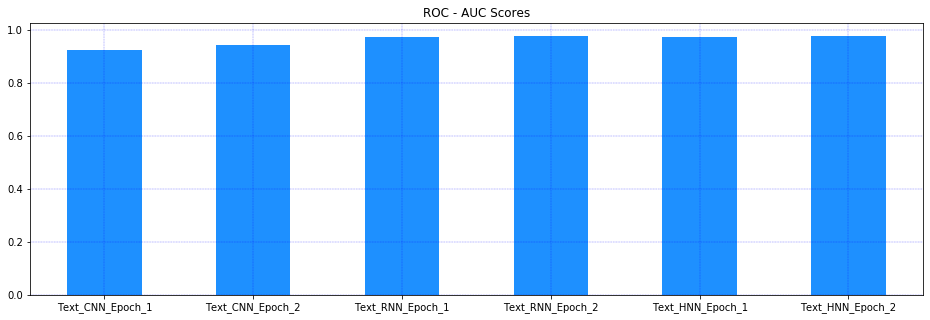

ROC-AUC Score:
Text_CNN_Epoch_1: 0.9251892632497937
Text_CNN_Epoch_2: 0.9453548713023004
Text_RNN_Epoch_1: 0.9742813146916517
Text_RNN_Epoch_2: 0.9766324215675709
Text_HNN_Epoch_1: 0.9730016557393072
Text_HNN_Epoch_2: 0.9773803107029764


In [36]:
dfaccuracies = pd.DataFrame(accuracies)
fig = dfaccuracies.plot.bar(figsize=(16, 5), color = 'dodgerblue')

Elabels = ["Text_CNN_Epoch_1","Text_CNN_Epoch_2","Text_RNN_Epoch_1","Text_RNN_Epoch_2","Text_HNN_Epoch_1","Text_HNN_Epoch_2"]

plt.xticks(np.arange(6),Elabels,rotation=0)

plt.legend().remove()
fig.set_title('ROC - AUC Scores')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.show()

print("\033[1m"+"ROC-AUC Score:"+"\033[0m")
for i in range(len(Elabels)):
    print("\033[1m"+Elabels[i]+":\033[0m",accuracies[i])

In [37]:
train, test = train_test_split(train, test_size=0.33, random_state=42, shuffle=True)

In [38]:
X_train = train['comment_text']
X_test = test['comment_text']

In [39]:
train.shape, test.shape

((106912, 8), (52659, 8))

In [40]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [41]:
accuracies2 = [[],[],[]]

# Linear SVC

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cvec = CountVectorizer()
tvec = TfidfTransformer()
from sklearn.svm import LinearSVC

In [43]:
X_train = tvec.fit_transform(cvec.fit_transform(X_train))
X_test = tvec.transform(cvec.transform(X_test))

In [44]:
from sklearn.svm import LinearSVC
model2 = LinearSVC()
for category in categories:
    model2.fit(X_train, train[category])
    accuracy = model2.score(X_test, test[category])
    accuracies2[0].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))

Accuracy For toxic Class Is 96.15%
Accuracy For severe_toxic Class Is 99.07%
Accuracy For obscene Class Is 97.9%
Accuracy For threat Class Is 99.75%
Accuracy For insult Class Is 97.19%
Accuracy For identity_hate Class Is 99.21%


# Mutlinominal Naive Bayes

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cvec = CountVectorizer()
tvec = TfidfTransformer()
model1 = MultinomialNB()

In [46]:
X_train.shape, X_test.shape

((106912, 149271), (52659, 149271))

In [47]:
for category in categories:
    model1.fit(X_train, train[category])
    accuracy = model1.score(X_test, test[category])
    accuracies2[1].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))

Accuracy For toxic Class Is 91.67%
Accuracy For severe_toxic Class Is 99.0%
Accuracy For obscene Class Is 95.02%
Accuracy For threat Class Is 99.71%
Accuracy For insult Class Is 95.13%
Accuracy For identity_hate Class Is 99.1%


# Logistic Regression Classifier

In [48]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression(n_jobs=1, solver='liblinear')
for category in categories:
    model3.fit(X_train, train[category])
    accuracy = model3.score(X_test, test[category])
    accuracies2[2].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))

Accuracy For toxic Class Is 95.62%
Accuracy For severe_toxic Class Is 99.1%
Accuracy For obscene Class Is 97.57%
Accuracy For threat Class Is 99.73%
Accuracy For insult Class Is 96.98%
Accuracy For identity_hate Class Is 99.17%


# COMPARE ACCURACY

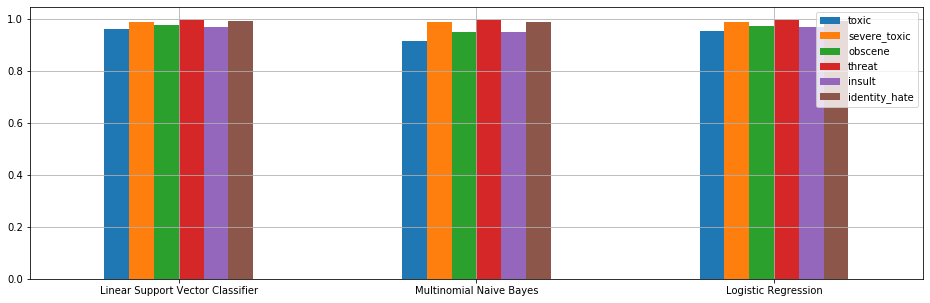

In [49]:
accuracies2 = pd.DataFrame(accuracies2)
fig = accuracies2.plot.bar(figsize=(16, 5), grid=True)
plt.xticks(np.arange(3),('Linear Support Vector Classifier','Multinomial Naive Bayes','Logistic Regression'),rotation=0)

plt.legend(list_classes)
plt.show()

In [50]:
for i in range(3):
    print("Model -",i+1,"... Aggregate Accuracy -",np.mean(accuracies2.iloc[i,:]))

Model - 1 ... Aggregate Accuracy - 0.9821049899668939
Model - 2 ... Aggregate Accuracy - 0.9660773403723327
Model - 3 ... Aggregate Accuracy - 0.9802914348291206


In [ ]:
from sklearn import joblib

joblib.dump(stop_words,'stopwords.pkl') 
joblib.dump(text_clf_hnn,'model.pkl')
joblib.dump(tokenizer,'tokenizer.pkl')